# Person Identification by Gait on the Gotcha Dataset
Submitted by Marvin Brenner

## Overview of Tasks:
1) Extract frames from video, we don’t need all the frames but samples of consecutive
frames<br>
2) Use Real time Multi-Person 2D Pose Estimation Using Part Affinity Fields to detect the
skeleton of the subject in the frame, particularly his feature body points<br>
3) Store the position/coordinates of consecutive frame feature points in an array to create
the pattern array (the pattern array store informations about the subject movement
variations in time)<br>
4) Create a NN that use as input the pattern array and give us the user id as output:<br>
5) Use a lot of pattern array samples to train the network<br>
6) Try to reach the highest accuracy chosing the best loss function.<br>
7) Additionally classify if each video is inside, outside or with a flashlight

## Dataset Content Description:
Content of the Dataset, Folders:<br>
Inside each folder there are two numbers: first number is the number of the folder and the second number is the subject's ID. <br>
1_Indoor lights - cooperative  = there are videos of 62 subjects indoor and in cooperative way.<br> 
2_Indoor light - non cooperative = there are videos of 62 subjects indoor and in cooperative way. <br>
3_Indoor flash - cooperative  = there are videos of 62 subjects indoor with light on and flash on, in cooperative way.<br> 
4_Indoor flash - non cooperative = there are videos of 62 subjects indoor with light on and flash on, in non cooperative way. <br>
5_Outdoor - cooperative  = there are videos of 62 subjects outdoor in cooperative way. <br>
6_Outdoor - non cooperative = there are videos of 62 subjects outdoor in non cooperative way. <br>
7_180 head video =  there are videos of the face in 180¡ (from ear to ear) of 62 subjects.<br>
8_Stairs - cooperative = there are videos of 6 subjects climbing the stairs in 3 different angles with 3 different devices (A-B-C), in cooperative way.<br>
9_Stairs - non cooperative =  there are videos of 6 subjects climbing the stairs in 3 different angles with 3 different devices (A-B-C), in non cooperative way.<br>
10_Outdoor path - cooperative = there are videos of 12 subjects walking outdoor along a path in cooperative way. (iPhone)<br>
11_Outdoor path - non cooperative = there are videos of 12 subjects walking outdoor along a path in non cooperative way. <br>(iPhone)
12_Derived file attached = there are two tipes of folders (1) HPE_x where x = 1, 2, 3, ... 62.  (2) Landmarks<br>

(1) HPE_x folder contains the 3D model of the subject x and 2223 images with the head rotated in pitch, yaw and roll<br>
(2) Landmarks folder contains Body landmarks and face landmarks of 62 subjects in the videos 1, 2, 3, 4, 5, 6.<br>

In [2]:
%matplotlib inline
import pandas as pd                                   # for working with large dataframes
import numpy as np                                    # for working with efficient numpy arrays
import os                                             # for operating system
import shutil                                         # for more utilities
import csv                                            # for reading excel tables and similar files
import matplotlib.pyplot as plt                       # for plotting the images
import cv2                                            # for capturing videos
import math                                           # for mathematical operations
from keras.preprocessing import image                 # for preprocessing the images
from keras.utils import np_utils                      # some utilities
from skimage.transform import resize                  # for resizing images
from scipy import ndimage                             # for rotating images
from config_reader import config_reader               # for 2D pose estimation
from model.cmu_model import get_testing_model         # for loading the affinity model
import time                                           # capturing the time needed for some operations
from tqdm import tqdm_notebook as tqdm                # having progress bars for loops
from sklearn.model_selection import train_test_split  # splitting training and test data
from sklearn.preprocessing import OneHotEncoder       # Encoding labels to vectors
from keras.utils import to_categorical                # Encoding Labels to numbers
from keras.models import Sequential                   # Building network architecture
from keras.layers import Dense, BatchNormalization, LSTM, Conv2D, Conv3D, Flatten    # Neural Network Layers
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

wpath = os.getcwd()
print ("The current working directory is %s" % wpath)

The current working directory is C:\Users\marvi\Desktop\CASA_Handin_Marvin_Brenner-master\CASA_Handin_Marvin_Brenner-master


# Steps of first Notebook
1) Extracting the Frames from the Videos <br>
2) Performing 2D Pose Estimation and storing the Joint Positions<br>

# 3) Loading the extracted Joint Data and storing the positions over time

Now I'm loading all the joint XY coordinates from the textfiles and put them into a structured array.<br>
All 44.023 samples consists of the ID of a subject, the File name including the Frame number and XY coordinates of the 18 joints.

In [4]:
path = './joint_data/'


dataframe = []
coords = []
framecoords= []
prev_t = np.array([46.6,120.8])  #just giving an average value for missing ones

n=1
for filename in tqdm(sorted(os.listdir(path))):
    
    if('frame' in filename):
        
        framecoords= []
        name = filename[0:-4]
        
        #read the joint file
        label = filename[2:5]
        f = open(path+filename, 'r')
        lines = f.readlines()
        count = len(lines)
               
        #get the XY-coordinates of every joint
        for line in lines[1:]:
            for string in line.splitlines():
                a = string.split(" ")
                a = a[0:-2]
                
                if(len(a)>2):
                    a[:]=a[0:2]
                    a = [float(x) for x in a]
                    
                elif(len(a)==0):
                    a=prev_t  # usually here you choose if you want to work with nan or not
                    
                elif("NaN" in a):
                    a=prev_t
                
                else:
                    a = [float(x) for x in a]
                    a = np.array(a)
                framecoords.append(a)
                
        #Normalizing the data
        #sc = StandardScaler()
        #framecoords = sc.fit_transform(framecoords)
        dataframe.append([label,
                          name[0:5],
                          name[11:],
                          framecoords[0][0],
                          framecoords[0][1],
                          framecoords[1][0],
                          framecoords[1][1],
                          framecoords[2][0],
                          framecoords[2][1],
                          framecoords[3][0],
                          framecoords[3][1],
                          framecoords[4][0],
                          framecoords[4][1],
                          framecoords[5][0],
                          framecoords[5][1],
                          framecoords[6][0],
                          framecoords[6][1],
                          framecoords[7][0],
                          framecoords[7][1],
                          framecoords[8][0],
                          framecoords[8][1],
                          framecoords[9][0],
                          framecoords[9][1],
                          framecoords[10][0],
                          framecoords[10][1],
                          framecoords[11][0],
                          framecoords[11][1],
                          framecoords[12][0],
                          framecoords[12][1],
                          framecoords[13][0],
                          framecoords[13][1],
                          framecoords[14][0],
                          framecoords[14][1],
                          framecoords[15][0],
                          framecoords[15][1],
                          framecoords[16][0],
                          framecoords[16][1],
                          framecoords[17][0],
                          framecoords[17][1],                 
                          ])
   
        file_contents = f.read()
        f.close()
    n=n+1

I looked up the correct order of Joints in the 2D Pose Estimation Paper to ensure all columns are named correctly

In [5]:
df = pd.DataFrame(dataframe, columns = ['ID','VideoNr','FrameNr' ,'noseX','noseY', 'neckX','neckY', 'right_shoulderX',
                                        'right_shoulderY','right_elbowX','right_elbowY','right_wristX', 'right_wristY',
                                        'left_shoulderX','left_shoulderY', 'left_elbowX', 'left_elbowY', 'left_wristX',
                                        'left_wristY', 'right_hipX', 'right_hipY', 'right_kneeX', 'right_kneeY', 
                                         'right_ankleX', 'right_ankleY', 'left_hipX','left_hipY', 'left_kneeX', 'left_kneeY',
                                         'left_ankleX',  'left_ankleY', 'left_eyeX', 'left_eyeY','right_eyeX', 'right_eyeY',
                                      'left_earX' ,'left_earY','right_earX','right_earY'])

In [7]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
df

,ID,VideoNr,FrameNr,noseX,noseY,neckX,neckY,right_shoulderX,right_shoulderY,right_elbowX,right_elbowY,right_wristX,right_wristY,left_shoulderX,left_shoulderY,left_elbowX,left_elbowY,left_wristX,left_wristY,right_hipX,right_hipY,right_kneeX,right_kneeY,right_ankleX,right_ankleY,left_hipX,left_hipY,left_kneeX,left_kneeY,left_ankleX,left_ankleY,left_eyeX,left_eyeY,right_eyeX,right_eyeY,left_earX,left_earY,right_earX,right_earY
0,001,1_001,00,32.0,53.0,25.0,72.0,0.0,72.0,46.6,120.8,46.6,120.8,47.0,73.0,52.0,101.0,54.0,127.0,8.0,136.0,10.0,179.0,46.6,120.8,35.0,137.0,28.0,181.0,46.6,120.8,27.0,48.0,35.0,48.0,18.0,48.0,40.0,49.0
1,001,1_001,01,31.0,52.0,25.0,72.0,0.0,72.0,46.6,120.8,46.6,120.8,46.0,73.0,52.0,100.0,54.0,127.0,8.0,136.0,9.0,181.0,46.6,120.8,34.0,137.0,27.0,181.0,46.6,120.8,26.0,47.0,35.0,48.0,17.0,47.0,39.0,49.0
2,001,1_001,010,28.0,52.0,22.0,72.0,0.0,72.0,46.6,120.8,46.6,120.8,44.0,71.0,51.0,99.0,53.0,125.0,5.0,137.0,6.0,180.0,46.6,120.8,32.0,137.0,23.0,179.0,46.6,120.8,23.0,47.0,31.0,47.0,13.0,47.0,36.0,47.0
3,001,1_001,0100,31.0,63.0,33.0,89.0,0.0,91.0,46.6,120.8,46.6,120.8,64.0,87.0,77.0,125.0,82.0,167.0,15.0,183.0,46.6,120.8,46.6,120.8,52.0,183.0,46.6,120.8,46.6,120.8,25.0,55.0,38.0,54.0,15.0,56.0,47.0,55.0
4,001,1_001,0101,31.0,64.0,33.0,89.0,0.0,91.0,46.6,120.8,46.6,120.8,64.0,87.0,77.0,126.0,81.0,168.0,14.0,183.0,46.6,120.8,46.6,120.8,51.0,183.0,46.6,120.8,46.6,120.8,23.0,55.0,37.0,55.0,14.0,56.0,46.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72617,062,6_062,095,49.0,74.0,46.0,92.0,32.0,95.0,26.0,121.0,37.0,141.0,59.0,89.0,67.0,111.0,71.0,128.0,49.0,142.0,54.0,177.0,57.0,191.0,66.0,137.0,77.0,171.0,67.0,191.0,46.0,72.0,51.0,71.0,38.0,73.0,46.6,120.8
72618,062,6_062,096,50.0,74.0,46.0,92.0,31.0,95.0,25.0,122.0,36.0,140.0,59.0,89.0,67.0,110.0,71.0,128.0,48.0,141.0,53.0,176.0,56.0,191.0,66.0,137.0,76.0,170.0,68.0,191.0,46.0,71.0,51.0,71.0,37.0,73.0,46.6,120.8
72619,062,6_062,097,50.0,74.0,45.0,92.0,31.0,95.0,25.0,121.0,36.0,140.0,59.0,89.0,66.0,111.0,70.0,128.0,48.0,141.0,52.0,175.0,56.0,191.0,66.0,137.0,75.0,170.0,46.6,120.8,46.0,71.0,51.0,71.0,37.0,73.0,46.6,120.8
72620,062,6_062,098,50.0,73.0,45.0,91.0,31.0,94.0,25.0,121.0,35.0,140.0,59.0,89.0,66.0,110.0,70.0,127.0,47.0,142.0,51.0,175.0,46.6,120.8,65.0,137.0,75.0,170.0,46.6,120.8,46.0,71.0,51.0,70.0,37.0,73.0,46.6,120.8


I looked up the correct order of Joints in the 2D Pose Estimation Paper to ensure all columns are named correctly

Joints like the ones of the nose and ears are less important for gait analysis, so before continuing I wanted to see which columns miss the most values. As you can see in the table below, unfortunately the ankles haven't been recognized correctly a lot of times, although they are important for gait analysis. 

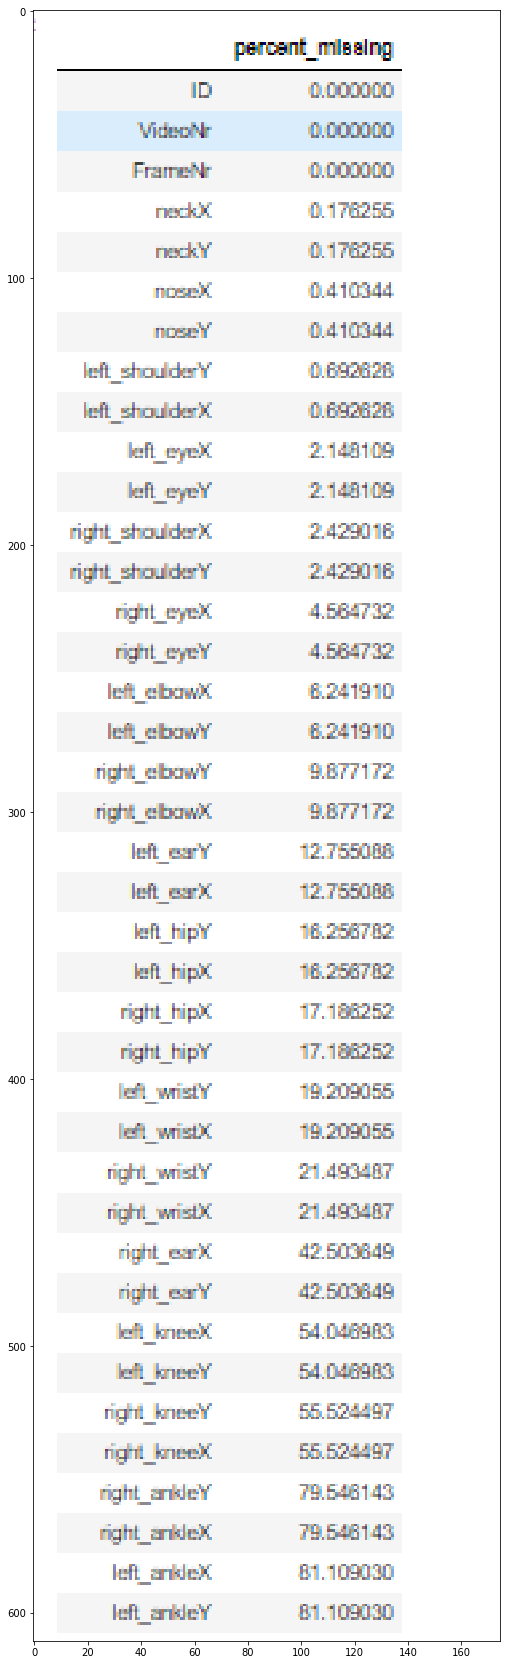

In [8]:
percent_missing = df.isnull().sum() * 100 / len(df) #to count nan
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})

#only works if missing values get replaced with nan
missing_value_df.sort_values('percent_missing', inplace=True)
#missing_value_df 
dummy = np.array(plt.imread('./missing.png'))
plt.rcParams['figure.figsize'] = [20, 30]
plt.imshow(dummy)

In order to have more balanced training data, I dropped the columns of the ankles and ears.

In [9]:
df2=df.drop(['left_ankleX','right_ankleX','left_earX', 'right_earX', 'left_kneeX', 'right_kneeX','left_eyeX','left_eyeY',
             'right_eyeX', 'right_eyeY','left_ankleY','right_ankleY','left_earY', 'right_earY', 'left_kneeY', 'right_kneeY'], axis=1)

Here I'm just fixing the naming of the frames

In [10]:
index = 0

#remove the dots of the frame names
for name in tqdm(df2.loc[:,("FrameNr")]):
    
    
    if(len(name)==2):
        name = "00"+name[-2:]
        df2["FrameNr"].loc[index] = name
        index = index+1
        
    elif(len(name)==3):
        name = "0"+name[-3:]
        df2["FrameNr"].loc[index] = name
        index = index+1
        
    else:
        index = index+1

C:\Users\marvi\Anaconda3\envs\pia\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
df2 = df2.sort_values(by =['VideoNr','FrameNr'], ascending=[True, True] )
df2

,ID,VideoNr,FrameNr,noseX,noseY,neckX,neckY,right_shoulderX,right_shoulderY,right_elbowX,right_elbowY,right_wristX,right_wristY,left_shoulderX,left_shoulderY,left_elbowX,left_elbowY,left_wristX,left_wristY,right_hipX,right_hipY,left_hipX,left_hipY
0,001,1_001,0000,32.0,53.0,25.0,72.0,0.0,72.0,46.6,120.8,46.6,120.8,47.0,73.0,52.0,101.0,54.0,127.0,8.0,136.0,35.0,137.0
1,001,1_001,0001,31.0,52.0,25.0,72.0,0.0,72.0,46.6,120.8,46.6,120.8,46.0,73.0,52.0,100.0,54.0,127.0,8.0,136.0,34.0,137.0
112,001,1_001,0002,31.0,52.0,25.0,72.0,2.0,71.0,46.6,120.8,46.6,120.8,46.0,72.0,52.0,100.0,54.0,126.0,8.0,136.0,34.0,137.0
154,001,1_001,0003,30.0,52.0,24.0,72.0,0.0,72.0,46.6,120.8,46.6,120.8,46.0,72.0,52.0,100.0,54.0,126.0,8.0,136.0,34.0,136.0
165,001,1_001,0004,30.0,52.0,24.0,71.0,0.0,71.0,46.6,120.8,46.6,120.8,45.0,72.0,52.0,100.0,54.0,126.0,7.0,137.0,33.0,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72529,062,6_062,0196,52.0,80.0,48.0,103.0,26.0,104.0,18.0,141.0,24.0,171.0,71.0,102.0,82.0,139.0,81.0,170.0,38.0,174.0,65.0,172.0
72530,062,6_062,0197,52.0,80.0,49.0,103.0,26.0,105.0,18.0,141.0,25.0,172.0,71.0,102.0,82.0,138.0,81.0,170.0,39.0,176.0,67.0,175.0
72531,062,6_062,0198,52.0,80.0,48.0,104.0,25.0,105.0,18.0,141.0,24.0,173.0,71.0,103.0,83.0,140.0,82.0,171.0,38.0,177.0,67.0,175.0
72532,062,6_062,0199,52.0,80.0,48.0,104.0,24.0,106.0,18.0,143.0,25.0,175.0,71.0,103.0,84.0,140.0,83.0,172.0,38.0,177.0,67.0,175.0


In [12]:
df2.to_csv(r'./df/df2.csv')

# Scaling the Features

Additional Parameters for recognizing gait: <br>

Not possible due to missing joints:<br>
• Step length: it is the short step length, obtained by the linear distance between two
successive placements of the same foot<br>
• Stride length: or long length obtained by the linear distance between the placements of
both feet<br>
• Step width: it is the linear distance between two equivalent points of both feet<br>
• Step angle: it is the direction of the foot during the step<br>
• Cadence: or rhythm, is the number of steps per time unit -> barely any differences in the videos used, because the distance walked is almost always the same<br>



Possible:<br>
• Gait phases: as the phases of the steps<br>
• Body posture: in terms of bending, symmetry etc<br>


In [13]:
df3 = df2.copy()

Here I define some additional features to identify a persons gait. These are the vertical differences between both shoulders, hips and elbows.

In [14]:
#symmetry of body posture
df3["shoulder_sym"] = df3["right_shoulderY"]-df3["left_shoulderY"]  #shoulder height difference in Y
df3["hip_sym"] = df3["right_hipY"]-df3["left_hipY"]                 #hip height difference in Y
df3["elbow_sym"] = df3["right_elbowY"]-df3["left_elbowY"]           #elbow height difference in Y

In [15]:
df3

,ID,VideoNr,FrameNr,noseX,noseY,neckX,neckY,right_shoulderX,right_shoulderY,right_elbowX,right_elbowY,right_wristX,right_wristY,left_shoulderX,left_shoulderY,left_elbowX,left_elbowY,left_wristX,left_wristY,right_hipX,right_hipY,left_hipX,left_hipY,shoulder_sym,hip_sym,elbow_sym
0,001,1_001,0000,32.0,53.0,25.0,72.0,0.0,72.0,46.6,120.8,46.6,120.8,47.0,73.0,52.0,101.0,54.0,127.0,8.0,136.0,35.0,137.0,-1.0,-1.0,19.8
1,001,1_001,0001,31.0,52.0,25.0,72.0,0.0,72.0,46.6,120.8,46.6,120.8,46.0,73.0,52.0,100.0,54.0,127.0,8.0,136.0,34.0,137.0,-1.0,-1.0,20.8
112,001,1_001,0002,31.0,52.0,25.0,72.0,2.0,71.0,46.6,120.8,46.6,120.8,46.0,72.0,52.0,100.0,54.0,126.0,8.0,136.0,34.0,137.0,-1.0,-1.0,20.8
154,001,1_001,0003,30.0,52.0,24.0,72.0,0.0,72.0,46.6,120.8,46.6,120.8,46.0,72.0,52.0,100.0,54.0,126.0,8.0,136.0,34.0,136.0,0.0,0.0,20.8
165,001,1_001,0004,30.0,52.0,24.0,71.0,0.0,71.0,46.6,120.8,46.6,120.8,45.0,72.0,52.0,100.0,54.0,126.0,7.0,137.0,33.0,138.0,-1.0,-1.0,20.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72529,062,6_062,0196,52.0,80.0,48.0,103.0,26.0,104.0,18.0,141.0,24.0,171.0,71.0,102.0,82.0,139.0,81.0,170.0,38.0,174.0,65.0,172.0,2.0,2.0,2.0
72530,062,6_062,0197,52.0,80.0,49.0,103.0,26.0,105.0,18.0,141.0,25.0,172.0,71.0,102.0,82.0,138.0,81.0,170.0,39.0,176.0,67.0,175.0,3.0,1.0,3.0
72531,062,6_062,0198,52.0,80.0,48.0,104.0,25.0,105.0,18.0,141.0,24.0,173.0,71.0,103.0,83.0,140.0,82.0,171.0,38.0,177.0,67.0,175.0,2.0,2.0,1.0
72532,062,6_062,0199,52.0,80.0,48.0,104.0,24.0,106.0,18.0,143.0,25.0,175.0,71.0,103.0,84.0,140.0,83.0,172.0,38.0,177.0,67.0,175.0,3.0,2.0,3.0


Here I scale all values with a scikit StandardScaler in order to prevent higher values to influence the neural network more

In [16]:
x = sc.fit_transform(df3[df3.columns[3:]])
x

array([[-1.12927363, -2.26794867, -1.70805981, ..., -0.71031847,
        -0.22672571,  0.98498225],
       [-1.20151047, -2.35859825, -1.70805981, ..., -0.71031847,
        -0.22672571,  1.04698512],
       [-1.20151047, -2.35859825, -1.70805981, ..., -0.71031847,
        -0.22672571,  1.04698512],
       ...,
       [ 0.31546318,  0.17958981,  0.25703455, ..., -0.13438329,
         0.08227436, -0.18067165],
       [ 0.31546318,  0.17958981,  0.25703455, ...,  0.0575951 ,
         0.08227436, -0.05666592],
       [ 0.31546318,  0.17958981,  0.25703455, ...,  0.0575951 ,
        -0.02072567, -0.11866879]])

In [17]:
df3[df3.columns[3:]]=x

Here I display the final dataframe , now it only needs to be balanced in terms of the count per class and we still need to calculate the actual movement, right now we are just looking at 2d coordinate skeletons per frame which are easy to classify for a neural network, especially considering there is only one camera angle.

In [20]:
df3 = df3.sort_values(by =['VideoNr','FrameNr'], ascending=[True, True] )
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)

df3

,ID,VideoNr,FrameNr,noseX,noseY,neckX,neckY,right_shoulderX,right_shoulderY,right_elbowX,right_elbowY,right_wristX,right_wristY,left_shoulderX,left_shoulderY,left_elbowX,left_elbowY,left_wristX,left_wristY,right_hipX,right_hipY,left_hipX,left_hipY,shoulder_sym,hip_sym,elbow_sym
0,001,1_001,0000,-1.129274,-2.267949,-1.708060,-2.356707,-2.134231,-2.503787,1.654845,-0.673703,1.194922,-1.187371,-1.149381,-2.095718,-1.121447,-1.393469,-0.860869,-0.715916,-3.095917,-0.599219,-1.948181,-0.513795,-0.710318,-0.226726,0.984982
1,001,1_001,0001,-1.201510,-2.358598,-1.708060,-2.356707,-2.134231,-2.503787,1.654845,-0.673703,1.194922,-1.187371,-1.217894,-2.095718,-1.121447,-1.442371,-0.860869,-0.715916,-3.095917,-0.599219,-2.034392,-0.513795,-0.710318,-0.226726,1.046985
112,001,1_001,0002,-1.201510,-2.358598,-1.708060,-2.356707,-1.974548,-2.582724,1.654845,-0.673703,1.194922,-1.187371,-1.217894,-2.170515,-1.121447,-1.442371,-0.860869,-0.758878,-3.095917,-0.599219,-2.034392,-0.513795,-0.710318,-0.226726,1.046985
154,001,1_001,0003,-1.273747,-2.358598,-1.793499,-2.356707,-2.134231,-2.503787,1.654845,-0.673703,1.194922,-1.187371,-1.217894,-2.170515,-1.121447,-1.442371,-0.860869,-0.758878,-3.095917,-0.599219,-2.034392,-0.556723,-0.518340,-0.123726,1.046985
165,001,1_001,0004,-1.273747,-2.358598,-1.793499,-2.434143,-2.134231,-2.582724,1.654845,-0.673703,1.194922,-1.187371,-1.286407,-2.170515,-1.121447,-1.442371,-0.860869,-0.758878,-3.193069,-0.556931,-2.120603,-0.470867,-0.710318,-0.226726,1.046985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72529,062,6_062,0196,0.315463,0.179590,0.257035,0.043800,-0.058358,0.022200,-0.465483,0.405571,-0.407100,0.906094,0.494936,0.073393,0.819759,0.464796,0.726972,1.131460,-0.181369,1.007721,0.638139,0.988684,-0.134383,0.082274,-0.118669
72530,062,6_062,0197,0.315463,0.179590,0.342473,0.043800,-0.058358,0.101137,-0.465483,0.405571,-0.336214,0.947796,0.494936,0.073393,0.819759,0.415895,0.726972,1.131460,-0.084217,1.092297,0.810560,1.117468,0.057595,-0.020726,-0.056666
72531,062,6_062,0198,0.315463,0.179590,0.257035,0.121236,-0.138199,0.101137,-0.465483,0.405571,-0.407100,0.989499,0.494936,0.148190,0.884466,0.513698,0.785781,1.174422,-0.181369,1.134585,0.810560,1.117468,-0.134383,0.082274,-0.180672
72532,062,6_062,0199,0.315463,0.179590,0.257035,0.121236,-0.218041,0.180074,-0.465483,0.512430,-0.336214,1.072904,0.494936,0.148190,0.949172,0.513698,0.844590,1.217384,-0.181369,1.134585,0.810560,1.117468,0.057595,0.082274,-0.056666


# Capturing the actual movements

In order for the neural network to learn the spatiotemporal relationship between the frames, I need to group them in a sequence, so I can feed it in a LSTM later. Below I grouped all frames by ID to make sure that there aren't any persons that have really few frames for the network to learn from<br>

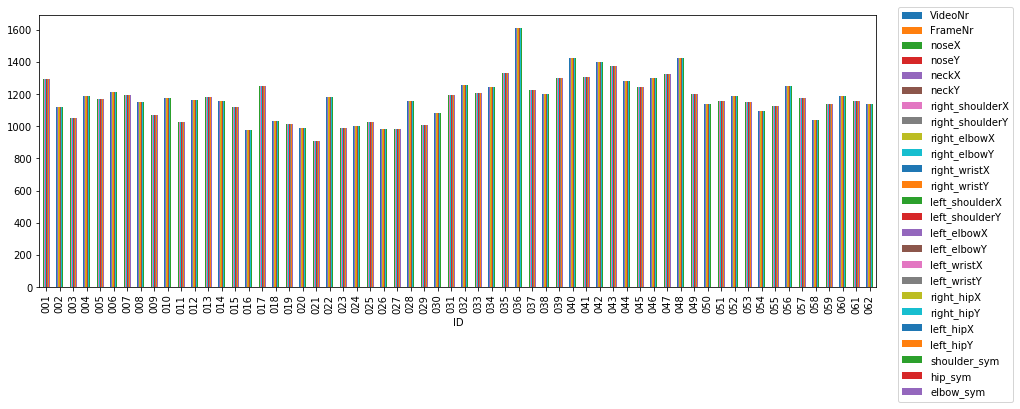

In [21]:
%matplotlib inline  
plt.rcParams['figure.figsize'] = [15, 5]
df3.groupby('ID').count().plot.bar(ylim=0)
plt.legend(bbox_to_anchor=(1.02, 1.05))
plt.show()

Here I squeeze all Video Numbers in the datas into a sorted set to loop through in order to make packages of 20 Frames from every video sample. That way the network has still enough frames but more samples to learn from.

In [22]:
df_b = df3.copy()
num_vid = list(sorted(set(df_b["VideoNr"].values)))
#num_vid

In [77]:
frames=[]
data_g = []
features=[]
pack = []

num_frame = 0

for video in tqdm(num_vid):
    
    gait=[]
    label=video[3:]
    frames=[]
    features=[]

    for row in range(0,len(df_b.index)):
                
        if(df_b.loc[row,("VideoNr")] == video):
            
            if(num_frame<=19): #how many frames there should be in one sample
                num_frame+=1
                features = df_b.loc[row,(df_b.columns[3:])].tolist()
                pack.append(features)
            else:
                data_g.append([label,video, pack])
                num_frame=0
                pack = []
                


In [78]:
df_3d = pd.DataFrame(data_g, columns = ["ID","Videoname", "Gait"])
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 80)
df_3d

,ID,Videoname,Gait
0,01,1_001,"[[-1.1292736326597999, -2.267948674760159, -1.7080598074739102, -2.356707234..."
1,01,1_001,"[[-1.7794052000369958, -1.2708033664747422, -1.537182037451046, -0.730556889..."
2,01,1_001,"[[-0.9847999510204231, -0.7269059255917876, -0.6827931873367263, -0.03363531..."
3,01,1_001,"[[-0.4791420652826042, -0.6362563521112952, 0.08615677776616157, 0.663286264..."
4,01,1_001,"[[-0.3346683836432274, -1.6334016603967119, 0.34247343280045756, 0.043800418..."
...,...,...,...
3453,62,6_062,"[[0.09875266127490309, 0.36088895617412164, 0.0007178927547295815, -0.111071..."
3454,62,6_062,"[[1.1823052735702293, -0.7269059255917876, 1.0259845128919134, -1.0402998120..."
3455,62,6_062,"[[1.326778955209606, -0.5456067786308026, 1.1114233979033454, -0.88542835062..."
3456,62,6_062,"[[1.3990157960292946, -0.7269059255917876, 1.1968622829147775, -0.9628640813..."


The data now consists from 1190 Samples with 20 Frames each, which contain 23 features

In [79]:
print( str(  len(  df_3d["Gait"]          )) + " Samples"    )
print( str(  len(  df_3d["Gait"][0]       )) + " Frames per Sample"    )
print( str(  len(  df_3d["Gait"][0]    )) + " Joints per Frame"    )

print(np.array(df_3d["Gait"]).shape)
print(np.array(df_3d["Gait"][0]).shape)

3458 Samples
20 Frames per Sample
20 Joints per Frame
(3458,)
(20, 23)


# Removing Videos of Subjects with black Tshirt in front of black background

I noticed that the 2d pose estimation often fails with particular subjects that wear uniformly black colored tshirts and are filmed in front of the unfortunately black background. Here I dropped some samples that were particularly unlikely to get correct joint positions, even for human eyes.

In [200]:
df_final = df_3d.copy()
pd.set_option('display.max_rows', 100)
#df_final

In [201]:
To_remove = ["1_030","1_033","1_034","1_035","1_038" ,
             "2_008","2_030", "2_008", "2_034", "2_042", "2_044",
             "3_001", "3_008","3_017", "3_025","3_031" , "3_034", "3_044", "3_051","3_052",
              "4_008","4_030", "4_035", "4_044", 
             "1_003",  "2_003",  "3_003",  "4_003",  "5_003",  #"6_003",
             "1_012",  "2_012",  "3_012",  "4_012",  "5_012",  #"6_012",
             "1_017",  "2_017",  "3_017",  "4_017",  "5_017",  #"6_017",
             "1_025",  "2_025",  "3_025",  "4_025",  "5_025",  #"6_025",
             "1_026",  "2_026",  "3_026",  "4_026",  "5_026", # "6_026",
             "1_022",  "2_022",  "3_022",  "4_022",  "5_022", # "6_022",
             "1_053",  "2_053",  "3_053",  "4_053",  "5_053",  #"6_053",
             "1_045",  "2_045",  "3_045",  "4_045",  "5_045",  #"6_045",
             "1_052",  "2_052",  "3_052",  "4_052",  "5_052", #"6_052",
             "1_025",  "2_025",  "3_025",  "4_025",  "5_025", #"6_025",
             "1_046",  "2_046",  "3_046",  "4_046",  "5_046",#"6_046",
             "1_047",  "2_047",  "3_047",  "4_047",  "5_047",#"6_047",
             "1_050",  "2_050",  "3_050",  "4_050",  "5_050",#"6_050",
             "1_056",  "2_056",  "3_056",  "4_056",  "5_056" # ,"6_056",
            ]

In [202]:
df_final.index = [x for x in range(0, 3458)]
df_bup = df_final.copy()
pd.set_option('display.max_rows', 10)
df_final

,ID,Videoname,Gait
0,01,1_001,"[[-1.1292736326597999, -2.267948674760159, -1.7080598074739102, -2.356707234..."
1,01,1_001,"[[-1.7794052000369958, -1.2708033664747422, -1.537182037451046, -0.730556889..."
2,01,1_001,"[[-0.9847999510204231, -0.7269059255917876, -0.6827931873367263, -0.03363531..."
3,01,1_001,"[[-0.4791420652826042, -0.6362563521112952, 0.08615677776616157, 0.663286264..."
4,01,1_001,"[[-0.3346683836432274, -1.6334016603967119, 0.34247343280045756, 0.043800418..."
...,...,...,...
3453,62,6_062,"[[0.09875266127490309, 0.36088895617412164, 0.0007178927547295815, -0.111071..."
3454,62,6_062,"[[1.1823052735702293, -0.7269059255917876, 1.0259845128919134, -1.0402998120..."
3455,62,6_062,"[[1.326778955209606, -0.5456067786308026, 1.1114233979033454, -0.88542835062..."
3456,62,6_062,"[[1.3990157960292946, -0.7269059255917876, 1.1968622829147775, -0.9628640813..."


In [203]:
for video in To_remove:
    df_final = df_final[df_final.Videoname != video]

In [204]:
df_final

,ID,Videoname,Gait
0,01,1_001,"[[-1.1292736326597999, -2.267948674760159, -1.7080598074739102, -2.356707234..."
1,01,1_001,"[[-1.7794052000369958, -1.2708033664747422, -1.537182037451046, -0.730556889..."
2,01,1_001,"[[-0.9847999510204231, -0.7269059255917876, -0.6827931873367263, -0.03363531..."
3,01,1_001,"[[-0.4791420652826042, -0.6362563521112952, 0.08615677776616157, 0.663286264..."
4,01,1_001,"[[-0.3346683836432274, -1.6334016603967119, 0.34247343280045756, 0.043800418..."
...,...,...,...
3453,62,6_062,"[[0.09875266127490309, 0.36088895617412164, 0.0007178927547295815, -0.111071..."
3454,62,6_062,"[[1.1823052735702293, -0.7269059255917876, 1.0259845128919134, -1.0402998120..."
3455,62,6_062,"[[1.326778955209606, -0.5456067786308026, 1.1114233979033454, -0.88542835062..."
3456,62,6_062,"[[1.3990157960292946, -0.7269059255917876, 1.1968622829147775, -0.9628640813..."


# 4) Creating the Neural Network

Here I drop all the rows with missing datapoints, then use that Gait-Pattern as Input X and the ID-Column as the Labels Y.
Then I compare the shapes of the two vectors, in case something is missing.

In [205]:
# Data needs to be in the shape (sample, frame_number, coordinates)

#the pattern array needs to be a 3dimensional input for 3D CNN or LSTM
#(num_samples, framenumber(t), coordinates of the joints)

In [206]:
print( str(  len(  df_final["Gait"]          )) + " Samples"    )
print( str(  len(  df_final["Gait"][0]       )) + " Frames per Sample"    )
print( str(  len(  df_final["Gait"][0][0]    )) + " Joints per Frame"    )


print(np.array(df_final["Gait"]).shape)
print(np.array(df_final["Gait"][0]).shape)

2698 Samples
20 Frames per Sample
23 Joints per Frame
(2698,)
(20, 23)


In [207]:
X = np.array([x for x in df_final["Gait"]])
y = np.array(df_final["ID"])

#X=X.reshape((366, 120, 12, 2))
print(X.shape)
print(y.shape)

(2698, 20, 23)
(2698,)


Here I encode the IDs into vector labels and scale all the inputs, to balance the input data. Otherwise the validation loss is oscillating strongly because some coordinates are way higher than others and get weighted more than they should.

In [208]:
#Encoding the IDs
y_enc = to_categorical(y,63)

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.1, random_state=42)
print(X_train.shape)
print(y_train.shape)

(2428, 20, 23)
(2428, 63)


In [210]:
import tensorflow as tf

If you are using Cuda support for nvidia graphic cards, you can actually use CuDNNLSTM this way, which gives a calculation boost of about 15 times the speed of the normal LSTM because it not only uses parallel calculations of the gpu but is also optimized for it, instead of cpu computation.

In [217]:
from keras.layers import Dense, BatchNormalization, LSTM, Conv2D, Conv3D, Flatten, CuDNNLSTM
from keras.models import Sequential   
from keras import regularizers


# Neural network
model = Sequential()

#270, 46, 15, 3

#Input Layer
model.add(CuDNNLSTM(512, input_shape=(20, 23),
              kernel_regularizer=regularizers.l2(0.01),
              recurrent_regularizer=None,
              bias_regularizer=regularizers.l2(0.01),
              return_sequences=True))


model.add(BatchNormalization(name='BatchNormalization1'))

#Layer 2

model.add(CuDNNLSTM(256, kernel_regularizer=regularizers.l2(0.01),
              recurrent_regularizer=None,
              bias_regularizer=regularizers.l2(0.01),
              return_sequences=True))

model.add(BatchNormalization(name='BatchNormalization2'))

#Layer 3

model.add(Dense(128, activation='tanh', name='Layer3'))
model.add(BatchNormalization(name='BatchNormalization3'))

#Layer 4
model.add(Dense(64, activation='tanh', name='Layer4'))
model.add(BatchNormalization(name='BatchNormalization4'))

#Dense Layer
model.add(Flatten())
model.add(Dense(63, activation='softmax',name='Final_Layer'))

In [218]:
from keras.optimizers import SGD
opt = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

In [219]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_23 (CuDNNLSTM)    (None, 20, 512)           1099776   
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 20, 512)           2048      
_________________________________________________________________
cu_dnnlstm_24 (CuDNNLSTM)    (None, 20, 256)           788480    
_________________________________________________________________
BatchNormalization2 (BatchNo (None, 20, 256)           1024      
_________________________________________________________________
Layer3 (Dense)               (None, 20, 128)           32896     
_________________________________________________________________
BatchNormalization3 (BatchNo (None, 20, 128)           512       
_________________________________________________________________
Layer4 (Dense)               (None, 20, 64)            8256      
__________

# 5) Training the Network

The classes are relatively unbalanced, because some videos provide more frames than others. Instead of removing the frames to balance it out, I weighted the class labels depending on occurrence.

In [220]:
#df3.ID.value_counts()

In [221]:
from sklearn.utils import compute_class_weight

y_w = [np.argmax(x) for x in y_train]
classWeight = compute_class_weight('balanced', np.unique(y_w), y_w) 
classWeight = dict(enumerate(classWeight))

#This below is to solve a Keras bug where it doesn't accept an equal number of labels
classWeight[62] = 1.0061770761839397
classWeight[63] = 1.0747800586510263
classWeight[0] = 1
classWeight[1] = 1 

I tried many different hyperparameters but found that this batch size and epoch count works best for the model

In [222]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=400, batch_size=16, verbose = 2, class_weight=classWeight)

Train on 2428 samples, validate on 270 samples
Epoch 1/400
 - 4s - loss: 21.0129 - acc: 0.0391 - val_loss: 19.0175 - val_acc: 0.0778
Epoch 2/400
 - 1s - loss: 19.7999 - acc: 0.0844 - val_loss: 18.6686 - val_acc: 0.0704
Epoch 3/400
 - 1s - loss: 19.2283 - acc: 0.1116 - val_loss: 18.4084 - val_acc: 0.0815
Epoch 4/400
 - 1s - loss: 18.8715 - acc: 0.1314 - val_loss: 18.0896 - val_acc: 0.1259
Epoch 5/400
 - 1s - loss: 18.4780 - acc: 0.1619 - val_loss: 17.9467 - val_acc: 0.1407
Epoch 6/400
 - 1s - loss: 18.2268 - acc: 0.1833 - val_loss: 17.7882 - val_acc: 0.1556
Epoch 7/400
 - 1s - loss: 17.9205 - acc: 0.1998 - val_loss: 17.6115 - val_acc: 0.1741
Epoch 8/400
 - 1s - loss: 17.6845 - acc: 0.2257 - val_loss: 17.3540 - val_acc: 0.1926
Epoch 9/400
 - 1s - loss: 17.4633 - acc: 0.2492 - val_loss: 17.2649 - val_acc: 0.2333
Epoch 10/400
 - 1s - loss: 17.2184 - acc: 0.2636 - val_loss: 17.0507 - val_acc: 0.2444
Epoch 11/400
 - 1s - loss: 17.0109 - acc: 0.2867 - val_loss: 16.9143 - val_acc: 0.2407
Epoch

Epoch 95/400
 - 1s - loss: 9.1083 - acc: 0.8550 - val_loss: 10.3456 - val_acc: 0.5630
Epoch 96/400
 - 1s - loss: 9.0186 - acc: 0.8690 - val_loss: 10.1685 - val_acc: 0.6074
Epoch 97/400
 - 1s - loss: 8.9654 - acc: 0.8657 - val_loss: 10.2128 - val_acc: 0.5778
Epoch 98/400
 - 1s - loss: 8.9452 - acc: 0.8546 - val_loss: 10.0587 - val_acc: 0.5815
Epoch 99/400
 - 1s - loss: 8.8247 - acc: 0.8826 - val_loss: 10.1010 - val_acc: 0.5556
Epoch 100/400
 - 1s - loss: 8.7721 - acc: 0.8744 - val_loss: 9.9935 - val_acc: 0.5889
Epoch 101/400
 - 1s - loss: 8.7357 - acc: 0.8690 - val_loss: 9.9334 - val_acc: 0.5741
Epoch 102/400
 - 1s - loss: 8.6703 - acc: 0.8810 - val_loss: 9.9338 - val_acc: 0.5370
Epoch 103/400
 - 1s - loss: 8.6008 - acc: 0.8814 - val_loss: 9.8563 - val_acc: 0.5926
Epoch 104/400
 - 1s - loss: 8.5980 - acc: 0.8744 - val_loss: 9.8877 - val_acc: 0.5889
Epoch 105/400
 - 1s - loss: 8.5165 - acc: 0.8806 - val_loss: 9.7779 - val_acc: 0.5926
Epoch 106/400
 - 1s - loss: 8.4463 - acc: 0.8917 - val

Epoch 191/400
 - 1s - loss: 5.1739 - acc: 0.9415 - val_loss: 6.5927 - val_acc: 0.6185
Epoch 192/400
 - 1s - loss: 5.0902 - acc: 0.9526 - val_loss: 6.5517 - val_acc: 0.6296
Epoch 193/400
 - 1s - loss: 5.0654 - acc: 0.9539 - val_loss: 6.6245 - val_acc: 0.6259
Epoch 194/400
 - 1s - loss: 5.0508 - acc: 0.9448 - val_loss: 6.5534 - val_acc: 0.6037
Epoch 195/400
 - 1s - loss: 4.9955 - acc: 0.9596 - val_loss: 6.5439 - val_acc: 0.6185
Epoch 196/400
 - 1s - loss: 4.9822 - acc: 0.9526 - val_loss: 6.4646 - val_acc: 0.5926
Epoch 197/400
 - 1s - loss: 4.9821 - acc: 0.9440 - val_loss: 6.4694 - val_acc: 0.6333
Epoch 198/400
 - 1s - loss: 4.9396 - acc: 0.9506 - val_loss: 6.3691 - val_acc: 0.5926
Epoch 199/400
 - 2s - loss: 4.9169 - acc: 0.9465 - val_loss: 6.3725 - val_acc: 0.6148
Epoch 200/400
 - 2s - loss: 4.8880 - acc: 0.9530 - val_loss: 6.4626 - val_acc: 0.5963
Epoch 201/400
 - 1s - loss: 4.8823 - acc: 0.9460 - val_loss: 6.3914 - val_acc: 0.5852
Epoch 202/400
 - 1s - loss: 4.8474 - acc: 0.9493 - val

Epoch 287/400
 - 1s - loss: 3.0153 - acc: 0.9675 - val_loss: 4.6444 - val_acc: 0.5963
Epoch 288/400
 - 1s - loss: 3.0016 - acc: 0.9679 - val_loss: 4.5652 - val_acc: 0.6037
Epoch 289/400
 - 1s - loss: 2.9941 - acc: 0.9658 - val_loss: 4.5542 - val_acc: 0.6074
Epoch 290/400
 - 1s - loss: 3.0153 - acc: 0.9535 - val_loss: 4.6163 - val_acc: 0.6074
Epoch 291/400
 - 1s - loss: 2.9645 - acc: 0.9625 - val_loss: 4.6875 - val_acc: 0.6037
Epoch 292/400
 - 1s - loss: 2.9521 - acc: 0.9679 - val_loss: 4.6922 - val_acc: 0.5704
Epoch 293/400
 - 1s - loss: 2.9249 - acc: 0.9703 - val_loss: 4.5272 - val_acc: 0.6370
Epoch 294/400
 - 1s - loss: 2.8992 - acc: 0.9741 - val_loss: 4.6002 - val_acc: 0.6259
Epoch 295/400
 - 1s - loss: 2.9173 - acc: 0.9654 - val_loss: 4.4629 - val_acc: 0.6074
Epoch 296/400
 - 1s - loss: 2.9485 - acc: 0.9485 - val_loss: 4.5864 - val_acc: 0.6000
Epoch 297/400
 - 1s - loss: 2.8862 - acc: 0.9572 - val_loss: 4.4761 - val_acc: 0.6296
Epoch 298/400
 - 1s - loss: 2.8650 - acc: 0.9642 - val

Epoch 383/400
 - 1s - loss: 1.8391 - acc: 0.9761 - val_loss: 3.5363 - val_acc: 0.6148
Epoch 384/400
 - 1s - loss: 1.8234 - acc: 0.9811 - val_loss: 3.4898 - val_acc: 0.6185
Epoch 385/400
 - 1s - loss: 1.8056 - acc: 0.9773 - val_loss: 3.5216 - val_acc: 0.6111
Epoch 386/400
 - 1s - loss: 1.8220 - acc: 0.9745 - val_loss: 3.5503 - val_acc: 0.6185
Epoch 387/400
 - 1s - loss: 1.7798 - acc: 0.9843 - val_loss: 3.4751 - val_acc: 0.6111
Epoch 388/400
 - 1s - loss: 1.7923 - acc: 0.9757 - val_loss: 3.4973 - val_acc: 0.5963
Epoch 389/400
 - 1s - loss: 1.7767 - acc: 0.9769 - val_loss: 3.4747 - val_acc: 0.6185
Epoch 390/400
 - 1s - loss: 1.7629 - acc: 0.9782 - val_loss: 3.4933 - val_acc: 0.6296
Epoch 391/400
 - 1s - loss: 1.8015 - acc: 0.9666 - val_loss: 3.5443 - val_acc: 0.5815
Epoch 392/400
 - 1s - loss: 1.9212 - acc: 0.9296 - val_loss: 3.5357 - val_acc: 0.5704
Epoch 393/400
 - 1s - loss: 1.7822 - acc: 0.9638 - val_loss: 3.5045 - val_acc: 0.6148
Epoch 394/400
 - 1s - loss: 1.8273 - acc: 0.9498 - val

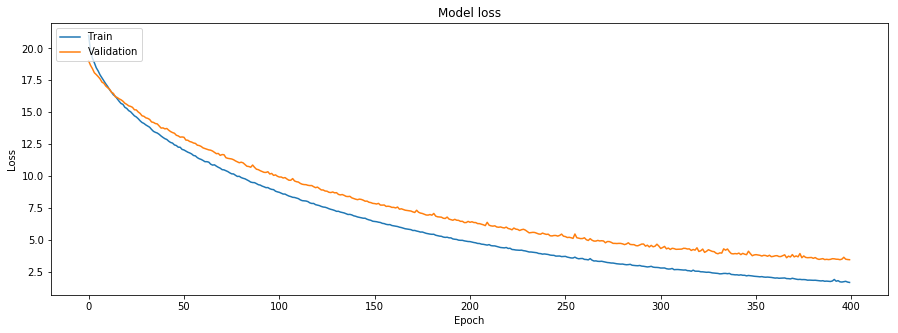

In [223]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 

plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

After taking a look at the loss, I always calculate the overall accuracy of the models predictions

In [225]:
y_pred = model.predict(X_test)

#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [226]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy on the Validation Data is:', a*100)

Accuracy on the Validation Data is: 60.0


Below is the precision and accuracy for each class, interestingly some are way harder to predict than others because some subjects for example where black tshirts in front of black backgrounds and are therefore missing joints.

In [227]:
from sklearn.metrics import classification_report

y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

C:\Users\marvi\Anaconda3\envs\pia\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       1.00      0.33      0.50         3
           4       0.50      0.33      0.40         3
           5       1.00      0.86      0.92         7
           6       1.00      0.60      0.75         5
           7       0.75      1.00      0.86         6
           8       0.00      0.00      0.00         3
           9       0.67      0.67      0.67         6
          10       0.43      0.60      0.50         5
          11       0.67      0.50      0.57         4
          12       0.00      0.00      0.00         0
          13       0.67      0.50      0.57         8
          14       0.67      0.25      0.36         8
          15       0.50      0.40      0.44         5
          16       1.00      0.50      0.67         4
          17       0.00      0.00      0.00         1
          18       0.50      0.40      0.44         5
          19       1.00    

# Indoor/Outdoor/Flashlight Classification

Now a neural network is trained to classify, whether each video is outdoor, indoor or filmed with a flashlight inside.
There for first, I define a dictionary to automatically label videos correctly based on their name.

In [228]:
classes = dict({'1':"Indoor light",
                '2':"Indoor light",
                '3':"Indoor flash",
                '4':"Indoor flash",
                '5':"Outdoor",
                '6':"Outdoor"
               })
classes['1']

'Indoor light'

Then I grab two frames from every video and put them in a dataframe, where they all have a label and a calculated histogram of their grayscale version. The Videos are already easily distinguishable by contrast differences, so no colors are needed. I just flatten them and then save their histogram in the array

In [246]:
path_frames = './lowres/'

frames = []
m=0

for file in tqdm(sorted(os.listdir(path_frames))):
   

    if('frame29' in file or 'frame10' in file): #takign frame number 29 from every video
        m+=1
        
        #get label
        label = classes[file[0]]
        
        #get one frame
        img = plt.imread(path_frames+file)
        img_n = np.array(img)
        
        #get histogram
        vals = img_n.mean(axis=2).flatten()  # calculate mean value from RGB channels and flatten to 1D array        
        h = np.histogram(vals, 255)  # plot histogram with 255 bins
        hist = np.array(h[0])
        
        frames.append([label,img_n,hist])
        cv2.destroyAllWindows()
        

print(str(m) + " frames found")

734 frames found


#### Below is the resulting dataframe:
Each histogram consists of an 1dimensional array with 255 values, one for each brightness level of rgb. The Image Array is just there to load the images if needed. They are in numpy array shape meaning 192 x 108 Pixels with 3 rgb color channels each.

In [247]:
df_c = pd.DataFrame(frames, columns = ["Label", "Image-Array","Histogram"])
df_c

,Label,Image-Array,Histogram
0,Indoor light,"[[[175, 178, 171], [175, 178, 171], [176, 179, 172], [177, 180, 173], [178, ...","[155, 515, 429, 404, 369, 301, 275, 229, 208, 199, 182, 152, 171, 153, 194, ..."
1,Indoor light,"[[[170, 175, 168], [171, 176, 169], [171, 176, 169], [171, 176, 169], [173, ...","[124, 482, 363, 380, 335, 280, 235, 200, 201, 169, 178, 174, 151, 161, 149, ..."
2,Indoor light,"[[[165, 167, 156], [164, 166, 155], [166, 168, 157], [167, 169, 158], [167, ...","[144, 442, 212, 630, 201, 163, 114, 98, 103, 83, 104, 80, 81, 74, 86, 138, 1..."
3,Indoor light,"[[[138, 141, 132], [145, 148, 139], [148, 151, 142], [150, 153, 144], [150, ...","[211, 864, 396, 278, 162, 110, 109, 109, 102, 120, 138, 133, 108, 129, 110, ..."
4,Indoor light,"[[[159, 161, 156], [155, 157, 152], [160, 162, 157], [162, 164, 159], [164, ...","[426, 913, 667, 764, 408, 340, 267, 312, 357, 406, 324, 277, 253, 304, 281, ..."
...,...,...,...
729,Outdoor,"[[[39, 17, 3], [99, 67, 29], [91, 56, 2], [91, 66, 12], [113, 97, 46], [128,...","[3, 9, 23, 16, 22, 33, 48, 51, 55, 82, 70, 74, 101, 89, 101, 89, 105, 81, 10..."
730,Outdoor,"[[[71, 48, 56], [230, 211, 178], [218, 211, 139], [121, 123, 50], [134, 136,...","[2, 0, 6, 6, 7, 9, 16, 13, 38, 41, 54, 49, 86, 67, 82, 93, 90, 97, 90, 109, ..."
731,Outdoor,"[[[114, 115, 133], [101, 108, 75], [148, 156, 81], [62, 64, 0], [93, 87, 25]...","[3, 1, 4, 4, 5, 12, 16, 19, 32, 46, 53, 58, 67, 86, 72, 92, 107, 103, 113, 1..."
732,Outdoor,"[[[82, 33, 0], [52, 21, 0], [42, 30, 8], [88, 76, 52], [75, 52, 18], [78, 50...","[2, 5, 14, 15, 22, 31, 30, 44, 35, 61, 63, 76, 72, 72, 82, 80, 86, 79, 113, ..."


Now I just use the Histogram Array as an Input X and the Labels as the Target Y

In [248]:
X = np.array([ x for x in df_c["Histogram"]])
y = np.array(df_c["Label"])
print(X.shape)
print(y.shape)

(734, 255)
(734,)


Then I normalize the histogram data and encode the String Labels with a Labelencoder plus to Categorical,
in order to be able to train with Arrays containing only 1 and 0. Additionally I write a little decoding dictionary for later.

In [249]:
from sklearn.preprocessing import StandardScaler

#Normalizing the data
sc = StandardScaler()
X = sc.fit_transform(X)

#Encoding the Labels
label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(y)
y_enc = to_categorical(vec)

decode = dict({0:'indoor flash',
               1:'indoor Light',
               2:'outdoor'})

C:\Users\marvi\Anaconda3\envs\pia\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\marvi\Anaconda3\envs\pia\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


As always the data gets split 9:1 in training and validation data

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.1, random_state=42)
print(X_train.shape)
print(y_train.shape)

(660, 255)
(660, 3)


Here I use a really tiny network to not immediately overfit, because the amount of data is so small.

In [251]:
# Neural network
model = Sequential()

#Input Layer
model.add(Dense(4, input_shape=(255,), activation='relu',name='Input_Layer'))
model.add(BatchNormalization(name='BatchNormalization1'))

#Final Layer
model.add(Dense(3, activation='softmax',name='Final_Layer'))

In [252]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Dense)          (None, 4)                 1024      
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 4)                 16        
_________________________________________________________________
Final_Layer (Dense)          (None, 3)                 15        
Total params: 1,055
Trainable params: 1,047
Non-trainable params: 8
_________________________________________________________________


Already after 6 epochs, the training is done:

In [253]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=6, batch_size=32)

Train on 660 samples, validate on 74 samples
Epoch 1/6
660/660 [==============================] - ETA: 37s - loss: 1.1969 - acc: 0.28 - ETA: 0s - loss: 0.8368 - acc: 0.6897 - 2s 3ms/step - loss: 0.7644 - acc: 0.7561 - val_loss: 0.5926 - val_acc: 0.8649
Epoch 2/6
660/660 [==============================] - ETA: 0s - loss: 0.6547 - acc: 0.875 - ETA: 0s - loss: 0.5247 - acc: 0.918 - 0s 113us/step - loss: 0.5097 - acc: 0.9242 - val_loss: 0.4837 - val_acc: 0.8919
Epoch 3/6
660/660 [==============================] - ETA: 0s - loss: 0.4300 - acc: 0.937 - ETA: 0s - loss: 0.4202 - acc: 0.957 - 0s 116us/step - loss: 0.4168 - acc: 0.9545 - val_loss: 0.4127 - val_acc: 0.9054
Epoch 4/6
660/660 [==============================] - ETA: 0s - loss: 0.4347 - acc: 0.937 - ETA: 0s - loss: 0.3890 - acc: 0.956 - 0s 124us/step - loss: 0.3795 - acc: 0.9561 - val_loss: 0.3636 - val_acc: 0.9324
Epoch 5/6
660/660 [==============================] - ETA: 0s - loss: 0.3008 - acc: 0.968 - ETA: 0s - loss: 0.3400 - acc:

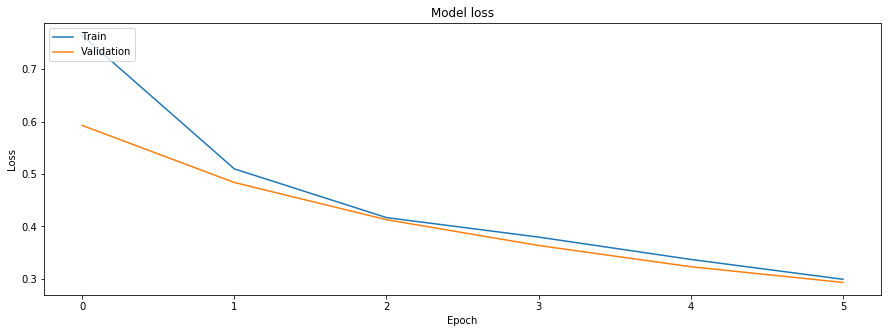

In [254]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

In [255]:
y_pred = model.predict(X_test)

#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

#Converting encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))
    
a = accuracy_score(pred,test)
print('Accuracy on the Validation Data is:', a*100)

Accuracy on the Validation Data is: 98.64864864864865


To test if our model is actually that accurate, we show it another random frame, it has never seen before:

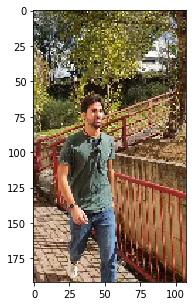

In [256]:
test = np.array(plt.imread('./lowres/5_026_frame03.jpg'))
plt.imshow(test)

In order to read its prediction, we need to decode the resulting label again:

In [257]:
#calculate the histogram of the image
proof = test.mean(axis=2).flatten()
h = np.histogram(proof, 255)
hist = np.array(h[0]).reshape(1,-1)

#make a prediciton
r = model.predict(hist)
re = np.argmax(r[0])
print('Neural Network thinks: "this Video might be ' + str(decode[re]) +'"')

Neural Network thinks: "this Video might be outdoor"
